<h1> CSCI 567 - Machine Learning - Spring 2021 </h1>
<h2> Project: Chekcpoint 1 - Data Preprocessing (03/10/21) </h2>
<h3> Team <u>StochasticResults</u>: </h3>
 - Abel Salinas [8793999216] [abelsali@usc.edu] <br>
 - Angel Nieto [2211798052] [nietogar@usc.edu] <br>
 - Misael Morales [5832732058] [misaelmo@usc.edu]

***

The "Housing Price" dataset consists of 79 predictors for the house prices in Ames, Iowa. The training and testing set are already pre-split for us from the Kaggle version (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview), and we will focus on different regression techniques to predict the housing SalePrice based on the given features.

This notebook focuses on the data pre-processing, wrangling, visualization, and statistical analysis. It is a crucial step in any machine-learning/data-analytics application to ensure proper data formatting in order to optimize the techniques implemented. 

# Table of Contents:
1. Load required packages <br>
2. Data wrangling <br>
3. Data visualization <br>
4. Exploratory data analysis

***

# 1. Load required libraries

In [30]:
# Basic data management packages
import os
import numpy as np
import pandas as pd

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.plotting as pd_plot
%matplotlib inline

In [31]:
# Exploratory Data Analysis packages
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA  
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor

In [32]:
# Regression and Modeling packages
import tensorflow as tf
import keras
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

# Verify GPU compatibility
print("Tensorflow Version:", tf.__version__)
print("Tensorflow built with CUDA?", tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('CPU'))
print(tf.config.list_physical_devices('GPU'))
print("Num GPU Available:", len(tf.config.list_physical_devices('GPU')))

Tensorflow Version: 2.4.1
Tensorflow built with CUDA? False
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]
Num GPU Available: 0


In [33]:
# Preprocessing choice
# preprocessing_method = 'HousePreprocessor'
preprocessing_method = 'Mappings'

***

# 2. Data Wrangling

In [34]:
# Read CSV files for Train/Test datasets
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')

After loading the data, we display the dataframe shapes for the training and testing sets. We notice that they are not the same shape, and therefore we will have to investigate the reason for this, and try to solve as best as possible. The original training set contains 1460 samples of 81 features, while the original testing set contains 1459 samples of 80 features. We can throw away the "Id" column, and obtain the true 79-feature datasets.

We also see that there are a lot of features that contain NaN's, as well as a mixture of numeric and string types for the predictors. This will become problematic for some regression techniques, and therefore we must devise a technique to transform as best as possible all data into numeric.

In [35]:
print('Train Shape: {} | types: {} \nTest Shape:  {} | types: {}'.format(train_df.shape, pd.unique(train_df.dtypes), 
                                                                       test_df.shape, pd.unique(test_df.dtypes)))
print('Set difference train-vs-test: {}'.format(set(train_df.columns).difference(set(test_df.columns))))

Train Shape: (1460, 81) | types: [dtype('int64') dtype('O') dtype('float64')] 
Test Shape:  (1459, 80) | types: [dtype('int64') dtype('O') dtype('float64')]
Set difference train-vs-test: {'SalePrice'}


In [36]:
x_train = train_df.iloc[:,1:-1]  #79 train features
y_train = train_df.iloc[:,-1]    #SalePrice training target
x_test  = test_df.iloc[:,1:]     #79 test features
print('x_train {} | y_train {} \nx_test  {}'.format(x_train.shape, y_train.shape, x_test.shape))

x_train (1460, 79) | y_train (1460,) 
x_test  (1459, 79)


We preview the first 5 rows of the training set. This allows to explore the data type for some of the features provided in this set. From here, we realize that 79 features is a very large number of features to visually display each time, and so we will restrict future visualizations to the most important features, or the features of interests for the specific operations we are performing at the moment.

In [37]:
#preview the training data set
x_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [38]:
#preview the testing data set
x_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


We check to see how many of the features in the training set are categorical and how many are numerical. We see an almost even split, and therefore we are going to have to change the categorical predictors from strings into some sort of integer mapping.

In [39]:
numerical_feats = x_train.dtypes[x_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = x_train.dtypes[x_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  36
Number of Categorical features:  43


We also count to see what percentage of the features are NaNs. For some variables, we observe a lot of missing data. This might indicate that it could be worth eliminating these features where the majority of the data is null.

In [40]:
total = x_train.isnull().sum().sort_values(ascending=False)
percent = (x_train.isnull().sum()/x_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageQual,81,0.055479
GarageCond,81,0.055479


Let's now focus on fixing the training and testing features in order to remove NaN's, change strings and objects into numerics, and other important data preprocessing and wrangling operations. We will go one-by-one on the features that require some fixing or reinterpretation for future regression modeling.

In [41]:
# Non-numeric variables that require attention
non_num_vars = x_train.dtypes[x_train.dtypes=='object'].index
print(non_num_vars)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


It is also important to know that some features have a slightly different definition than others in terms of their categorical values. For PoolQC, for example, NaN is not missing data but means no pool, likewise for Fence, FireplaceQu etc.

In [42]:
# Replace object/string values with categorial values from the "data_description" file from Kaggle
mappings = dict(
MSZoning_mapping      = {'nan':0, 'A':1, 'C (all)':2, 'FV':3, 'I':4, 'RH':5, 'RL':6, 'RP':7, 'RM':8},
Street_mapping        = {'nan':0, 'Grvl':1, 'Pave':2},
Alley_mapping         = {'nan':0, 'Grvl':1, 'Pave':2, 'NaN':0},
LotShape_mapping      = {'nan':0, 'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4 },
LandContour_mapping   = {'nan':0, 'Lvl':1, 'Bnk':2, 'HLS':3, 'Low':4},
Utilities_mapping     = {'nan':0, 'AllPub':1, 'NoSewr':2, 'NoSeWa':3, 'ELO':4},
LotConfig_mapping     = {'nan':0, 'Inside':1, 'Corner':2, 'CulDSac':3, 'FR2':4, 'FR3':5},
LandSlope_mapping     = {'nan':0, 'Gtl':1, 'Mod':2, 'Sev':3},
Neighborhood_mapping  = {'nan':0, 'Blmngtn':1, 'Blueste':2, 'BrDale':3, 'BrkSide':4, 'ClearCr':5, 'CollgCr':6, 'Crawfor':7,
                         'Edwards':8, 'Gilbert':9, 'IDOTRR':10, 'MeadowV':11, 'Mitchel':12, 'NAmes':13, 'NoRidge':14, 
                         'NPkVill':15, 'NridgHt':16, 'NWAmes':17, 'OldTown':18, 'SWISU':19, 'Sawyer':20, 'SawyerW':21, 
                         'Somerst':22, 'StoneBr':23, 'Timber':24, 'Veenker':25},
Condition1_mapping    = {'nan':0, 'Artery':1, 'Feedr':2, 'Norm':3, 'RRNn':4, 'RRAn':5, 'PosN':6, 'PosA':7, 'RRNe':8, 'RRAe':9},
Condition2_mapping    = {'nan':0, 'Artery':1, 'Feedr':2, 'Norm':3, 'RRNn':4, 'RRAn':5, 'PosN':6, 'PosA':7, 'RRNe':8, 'RRAe':9},
BldgType_mapping      = {'nan':0, '1Fam':1, '2fmCon':2, 'Duplex':3, 'Twnhs':4, 'TwnhsE':4, 'TwnhsI':5},
HouseStyle_mapping    = {'nan':0, '1Story':1, '1.5Fin':2, '1.5Unf':3, '2Story':4, '2.5Fin':5, '2.5Unf':6, 'SFoyer':7, 'SLvl':8},
RoofStyle_mapping     = {'nan':0, 'Flat':1, 'Gable':2, 'Gambrel':3, 'Hip':4, 'Mansard':5, 'Shed':6},
RoofMatl_mapping      = {'nan':0, 'ClyTile':1, 'CompShg':2, 'Membran':3, 'Metal':4, 
                         'Roll':5, 'Tar&Grv':6, 'WdShake':7, 'WdShngl':8},
Exterior1st_mapping   = {'nan':0, 'AsbShng':1, 'AsphShn':2, 'BrkComm':3, 'BrkFace':4, 'CBlock':5, 'CemntBd':6, 
                         'HdBoard':7, 'ImStucc':8, 'MetalSd':9, 'Other':10, 'Plywood':11, 'PreCast':12, 'Stone':13, 
                         'Stucco':14, 'VinylSd':15,'Wd Sdng':16, 'WdShing':17},
Exterior2nd_mapping   = {'nan':0, 'AsbShng':1, 'AsphShn':2, 'Brk Cmn':3, 'BrkFace':4, 'CBlock':5, 'CmentBd':6, 
                         'HdBoard':7, 'ImStucc':8, 'MetalSd':9, 'Other':10, 'Plywood':11, 'PreCast':12, 'Stone':13, 
                         'Stucco':14, 'VinylSd':15, 'Wd Shng':16, 'Wd Sdng':16, 'WdShing':17},
MasVnrType_mapping    = {'nan':0, 'BrkCmn':1, 'BrkFace':2, 'CBlock':3, 'None':4, 'Stone':5},
ExterQual_mapping     = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5},
ExterCond_mapping     = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5},
Foundation_mapping    = {'nan':0, 'BrkTil':1, 'CBlock':2, 'PConc':3, 'Slab':4, 'Stone':5, 'Wood':6},
BsmtQual_mapping      = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5, 'NA':0},
BsmtCond_mapping      = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5, 'NA':0},
BsmtExposure_mapping  = {'nan':0, 'Gd':1, 'Av':2, 'Mn':3, 'No':4, 'NA':5},
BsmtFinType1_mapping  = {'nan':0, 'GLQ':1, 'ALQ':2, 'BLQ':3, 'Rec':4, 'LwQ':5, 'Unf':6, 'NA':0},
BsmtFinType2_mapping  = {'nan':0, 'GLQ':1, 'ALQ':2, 'BLQ':3, 'Rec':4, 'LwQ':5, 'Unf':6, 'NA':0},
Heating_mapping       = {'nan':0, 'Floor':1, 'GasA':2, 'GasW':3, 'Grav':4, 'OthW':5, 'Wall':6},
HeatingQC_mapping     = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5},
CentralAir_mapping    = {'nan':0, 'N':1, 'Y':2},
Electrical_mapping    = {'nan':0, 'SBrkr':1, 'FuseA':2, 'FuseF':3, 'FuseP':4, 'Mix':5},
KitchenQual_mapping   = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5},
Functional_mapping    = {'nan':0, 'Typ':1, 'Min1':2, 'Min2':3, 'Mod':4, 'Maj1':5, 'Maj2':6, 'Sev':7, 'Sal':8},
FireplaceQu_mapping   = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5, 'NA':0},
GarageType_mapping    = {'nan':0, '2Types':1, 'Attchd':2, 'Basment':3, 'BuiltIn':4, 'CarPort':5, 'Detchd':6, 'NA':0},
GarageFinish_mapping  = {'nan':0, 'Fin':1, 'RFn':2, 'Unf':3, 'NA':0},
GarageQual_mapping    = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5, 'NA':0},
GarageCond_mapping    = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5, 'NA':0},
PavedDrive_mapping    = {'nan':0, 'Y':1, 'P':2, 'N':3},
PoolQC_mapping        = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'NA':0},
Fence_mapping         = {'nan':0, 'GdPrv':1, 'MnPrv':2, 'GdWo':3, 'MnWw':4, 'NA':0},
MiscFeature_mapping   = {'nan':0, 'Elev':1, 'Gar2':2, 'Othr':3, 'Shed':4, 'TenC':5, 'NA':0},
SaleType_mapping      = {'nan':0, 'WD':1, 'CWD':2, 'VWD':3, 'New':4, 'COD':5, 'Con':6, 'ConLw':7, 'ConLI':8,
                         'ConLD':9, 'Oth':10},
SaleCondition_mapping = {'nan':0, 'Normal':1, 'Abnorml':2, 'AdjLand':3, 'Alloca':4, 'Family':5, 'Partial':6})

With the dictionaries for relabeling the object/string-types as integer classes, we can now recursively replace all of the unuseful features with more meaningful values. We also replace all NaN's with 0's, so that they don't have an impact on the future regression models.

In [43]:
class HousePreprocessor():
    def __init__(self, verbose=True):
        self.verbose = verbose
        # Cnvrt disp Vars
        self.disp_cats = [('Electrical', 'SBrkr'), ('BsmtFinType2', 'Unf')]
        
        # Cnvrt Relative Vars
        rating_order_map = {
            'Po': 0,
            'Fa': 1,
            'TA': 2,
            'Gd': 3,
            'Ex': 4,
            'NA': 'NA',
            np.nan: 'NA'
        }

        basement_exposure_map = {
            'No': 0,
            'Mn': 1,
            'Av': 2,
            'Gd': 3,
            'NA': 'NA',
            np.nan: 'NA'
        }

        basement_finish_map = {
            'Unf': 0,
            'LwQ': 1,
            'Rec': 2,
            'BLQ': 3,
            'ALQ': 4,
            'GLQ': 5,
            'NA': 'NA',
            np.nan: 'NA'
        }

        functional_rating = {
            'Sal': 0,
            'Sev': 1,
            'Maj2': 2,
            'Maj1': 3,
            'Mod': 4,
            'Min2': 5,
            'Min1': 6,
            'Typ': 7,
            'NA': 'NA',
            np.nan: 'NA'
        }

        garage_finish_rating = {
            'Unf': 0,
            'RFn': 1,
            'Fin': 2,
            'NA': 'NA',
            np.nan: 'NA'
        }

        fence_quality_rating = {
            "MnWw": 0,
            "GdWo": 1,
            "MnPrv": 2,
            "GdPrv": 3,
            "NA": "NA",
            np.nan: 'NA'
        }

        bool_map = {
            'N': 0,
            'Y': 1
        }

        self.relative_categories = (
            [(cat, rating_order_map) for cat in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']] + 
            [(cat, basement_exposure_map) for cat in ['BsmtExposure']] +
            [(cat, basement_finish_map) for cat in ['BsmtFinType1']] +
            [(cat, functional_rating) for cat in ['Functional']] +
            [(cat, garage_finish_rating) for cat in ['GarageFinish']] +
            [(cat, fence_quality_rating) for cat in ['Fence']] +
            [(cat, bool_map) for cat in ['CentralAir']]
        )
        
        # Cyclical Vars
        self.cyclical_features = ['MoSold']

        # Dummy Vars
        self.dummy_vars_to_append = ['MSSubClass']
        
    def process(self, df):
        df = self.__cnvrt_disp_class_vars__(df)
        df = self.__cnvrt_relative_cats__(df)
        df = self.__cnvrt_cyclical_vars__(df)
        
        self.__log_remaining_category_vars__(df)
        
        df =  self.__add_dummy_vars__(df)
        
        df = self.__cnvrt_na_to_avg__(df)
        
        return df
    
    def __cnvrt_disp_class_vars__(self, df):
        # Convert Disproportionate Classification Variables
        """
        NOTE: The electrical variable is disproportionately SBrkr. As a result, we will convert Electrical to a boolean of SBrkr vs Not SBrkr rather than creating more variables

        SBrkr - 1334 (91.5%)
        FuseA - 1    (0.05%)
        FuseF - 94   (6.5%)
        FuseP - 27   (1.8%)
        Mix   - 3    (0.25%)

        NOTE: The electrical variable is disproportionately SBrkr. As a result, we will convert Electrical to a boolean of SBrkr vs Not SBrkr rather than creating more variables

        GLQ - 14
        ALQ - 19
        BLQ - 33
        Rec - 54
        LwQ - 46
        Unf - 1256
        NA - 38


        Note: An argument could be made to do the same for BsmtExposure, though we have decided against converting it into a boolean variable

        GD - 134
        Av - 221
        Mn - 114
        No - 953
        NA - 38

        """       
        for cat, key in self.disp_cats:
            df[cat] = [1 if e == key else 0 for e in df[cat]]
            
        return df
            
    def __cnvrt_relative_cats__(self, df):
        # Convert Relative Categorical into numerical
        for cat, map in self.relative_categories:
            num_na = len([i for i in df[cat] if i is np.nan])
            df[cat] = [map[rating] for rating in df[cat]]
            cat_na = f'{cat}_NA'

            # Create Boolean NA Column
            df[cat_na] = [1 if v == 'NA' else 0 for v in df[cat]]

            assert(num_na == sum(df[cat_na]))

            # Convert NA to average (IS THIS REALLY THE BEST STRATEGY?)
            avg = np.average([i for i in df[cat] if i != 'NA'])
            df[cat] = [i if i != 'NA' else avg for i in df[cat]]
        return df
            
    def __cnvrt_cyclical_vars__(self, df):
        # Convert to cyclical (See for more information)
        for f in self.cyclical_features:
            df[f'{f}_sin'] = np.sin(df[f])
            df[f'{f}_cos'] = np.cos(df[f])
            df.drop(f, 1)
            
        return df
            
    def __log_remaining_category_vars__(self, df):
        if self.verbose:
            # Decide which categorical variables you want to use
            # TODO: Convert to bar chart
            for col_name in df.columns:
                if df[col_name].dtypes == 'object':
                    unique_cat = len(df[col_name].unique())
                    print(f'Feature {col_name} has {unique_cat} unique categories')
            
    def __add_dummy_vars__(self, df):           
        dummy_list = [col for col in df.columns if df[col].dtypes == 'object']
        dummy_list = dummy_list + self.dummy_vars_to_append
        
        for cat in dummy_list:
            dummies = pd.get_dummies(df[cat], prefix=cat, dummy_na=True)
            df = df.drop(cat, 1)
            df = pd.concat([df, dummies], axis=1)
            
        return df
    
    def __cnvrt_na_to_avg__(self, df):
        # NOTE: Since Garage YR blt has NA values, we have decided to deal with this by using the average year as the NA value 
        # (IS THIS REALLY THE BEST STRATEGY?)
        cols_with_na = df.isnull().sum().sort_values(ascending=False)
        cols_with_na = list(cols_with_na[cols_with_na > 0].keys())
        
        for col in cols_with_na:
            if self.verbose:
                print(f"Converting nan's in {col} to avg of {col}")
            
            avg = np.average([i for i in df[col] if not np.isnan(i)])
            df[col] = [avg if np.isnan(i) else i for i in df[col]]
        
        cols_with_na = df.isnull().sum().sort_values(ascending=False)
        cols_with_na = cols_with_na[cols_with_na > 0]
        assert 0 == cols_with_na.shape[0]
        
        return df       

In [44]:
if preprocessing_method == 'HousePreprocessor':
    hp = HousePreprocessor()
    x_train = hp.process(x_train)
    print("-------------------------")
    x_test = hp.process(x_test)
else:
    x_train = x_train.replace({list(non_num_vars)[k] : list(mappings.values())[k] 
                               for k in np.arange(len(list(non_num_vars)))}).fillna(0)
    x_test  = x_test.replace({list(non_num_vars)[k] : list(mappings.values())[k] 
                               for k in np.arange(len(list(non_num_vars)))}).fillna(0)

print('x_train {} | y_train {} \nx_test  {}'.format(x_train.shape, y_train.shape, x_test.shape))

x_train (1460, 79) | y_train (1460,) 
x_test  (1459, 79)


In [45]:
x_train.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,6,65.0,8450,2,0.0,1,1,1,1,...,0,0,0.0,0.0,0.0,0,2,2008,1,1
1,20,6,80.0,9600,2,0.0,1,1,1,4,...,0,0,0.0,0.0,0.0,0,5,2007,1,1
2,60,6,68.0,11250,2,0.0,2,1,1,1,...,0,0,0.0,0.0,0.0,0,9,2008,1,1


In [46]:
x_test.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,5.0,80.0,11622,2,0.0,1,1,1.0,1,...,120,0,0.0,2.0,0.0,0,6,2010,1.0,1
1,20,6.0,81.0,14267,2,0.0,2,1,1.0,2,...,0,0,0.0,0.0,2.0,12500,6,2010,1.0,1
2,60,6.0,74.0,13830,2,0.0,2,1,1.0,1,...,0,0,0.0,2.0,0.0,0,3,2010,1.0,1


We confirm that we are now rid of any NaN's and null values in the training and testing datasets.

In [47]:
print('Training set null values: %i' %x_train.isnull().sum().sum())
print('Testing set null values:  %i' %x_test.isnull().sum().sum())

Training set null values: 0
Testing set null values:  0


In [48]:
numerical_feats = x_train.dtypes[x_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = x_train.dtypes[x_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  79
Number of Categorical features:  0


***

# 3. Data Visualization

In [49]:
# Declare a function to plot a graphical correlation matrix 
def plot_corr(dataframe,size=8):                         
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0, cmap='seismic')
    #plt.xticks(range(len(corr.columns)), corr.columns);
    #plt.yticks(range(len(corr.columns)), corr.columns);
    plt.xticks([]); plt.yticks([])
    plt.colorbar(im, orientation = 'vertical', shrink=0.8)
    plt.title('Correlation Matrix')

We start by visualizing the correlation between the 79 predictors and the target variable. This will tell us which predictors are highly correlated with each other, as well as which predictors have the highest correlation with the target SalePrice. We then select the last row (or column) of the matrix and select which predictors have the highest correlation to the target.

In [50]:
corr_mat = np.corrcoef(x_train.join(y_train),rowvar = False)
corr_vec = corr_mat[:-1,-1]   #correlation of features to target only
print(corr_mat.round(2))            

[[ 1.    0.08 -0.22 ... -0.   -0.04 -0.08]
 [ 0.08  1.   -0.07 ... -0.13 -0.16 -0.21]
 [-0.22 -0.07  1.   ...  0.11  0.18  0.21]
 ...
 [-0.   -0.13  0.11 ...  1.    0.54  0.15]
 [-0.04 -0.16  0.18 ...  0.54  1.    0.29]
 [-0.08 -0.21  0.21 ...  0.15  0.29  1.  ]]


The following correlation matrix/heatmap shows the effect of multicollinearity for some highly correlated variables that might be describing the same thing. For some cases, it might be important to note that we don't always need those pairs 2 or more variables that essentially describe the same thing - such as totalbsmtSF and 1stflrSF, or garageCars and garageArea.

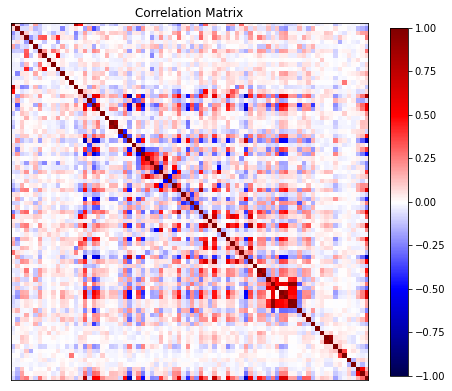

In [51]:
plot_corr(x_train.join(y_train))

The user selects a level of correlation to cut-off; meaning that anything between this percentage will be considered as uncorrelated. For instance, a corr_bound=0.7 means that anything between -0.7-to-0.7 is considered uncorrelated to SalePrice, while anything greater than 0.7 or less tha -0.7 is considered correlated. We further explore these correlated features to the target variables in different ways.

In [52]:
#View features that have a +/- correlation greater than the user-specified corrrelation bound (corr_bound)
corr_bound = 0.6
corr_dat = (x_train.iloc[:, corr_vec<-corr_bound]).join(x_train.iloc[:, corr_vec>corr_bound])
corr_dat

,ExterQual,KitchenQual,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageCars,GarageArea
0,2,2,7,856,856,1710,2,548
1,3,3,6,1262,1262,1262,2,460
2,2,2,7,920,920,1786,2,608
3,3,2,7,756,961,1717,3,642
4,2,2,8,1145,1145,2198,3,836
...,...,...,...,...,...,...,...,...
1455,3,3,6,953,953,1647,2,460
1456,3,3,6,1542,2073,2073,2,500
1457,1,2,7,1152,1188,2340,1,252
1458,3,2,5,1078,1078,1078,1,240


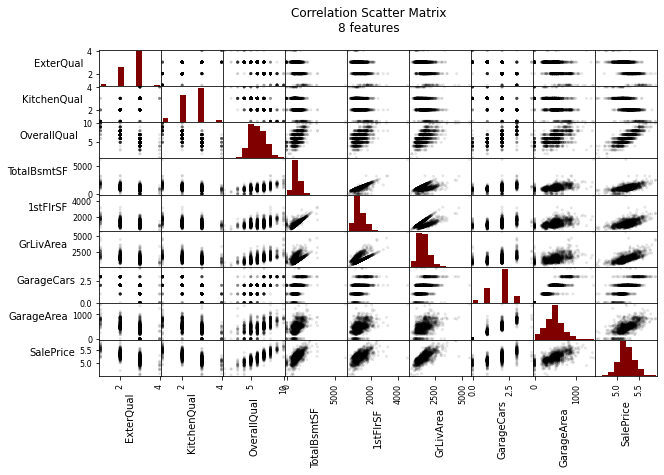

In [53]:
axes = pd_plot.scatter_matrix(corr_dat.join(np.log10(y_train)), alpha=0.1, figsize=(10, 6), 
                              color='black', hist_kwds={'color':['maroon']})
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.suptitle('Correlation Scatter Matrix\n{} features'.format(corr_dat.shape[-1]))
plt.show();

In [54]:
#full training set basic statistics
x_train.describe()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,6.126712,57.623288,10516.828082,1.995890,0.090411,1.408219,1.185616,1.001370,1.416438,...,15.060959,2.758904,0.010959,0.396575,0.144521,43.489041,6.321918,2007.815753,1.490411,1.582192
std,42.300571,1.050330,34.664304,9981.264932,0.063996,0.372151,0.582296,0.606509,0.052342,0.773448,...,55.757415,40.177307,0.177224,0.875914,0.742569,496.123024,2.703626,1.328095,1.368616,1.475209
min,20.000000,2.000000,0.000000,1300.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,1.000000,1.000000
25%,20.000000,6.000000,42.000000,7553.500000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,1.000000,1.000000
50%,50.000000,6.000000,63.000000,9478.500000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,1.000000,1.000000
75%,70.000000,6.000000,79.000000,11601.500000,2.000000,0.000000,2.000000,1.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,1.000000,1.000000
max,190.000000,8.000000,313.000000,215245.000000,2.000000,2.000000,4.000000,4.000000,3.000000,5.000000,...,480.000000,738.000000,4.000000,4.000000,5.000000,15500.000000,12.000000,2010.000000,10.000000,6.000000


In [55]:
#main features (based on correlation coefficient) basic statistics
corr_dat.describe()

,ExterQual,KitchenQual,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageCars,GarageArea
count,1460.00000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,2.60411,2.488356,6.099315,1057.429452,1162.626712,1515.463699,1.767123,472.980137
std,0.57428,0.663760,1.382997,438.705324,386.587738,525.480383,0.747315,213.804841
min,1.00000,1.000000,1.000000,0.000000,334.000000,334.000000,0.000000,0.000000
25%,2.00000,2.000000,5.000000,795.750000,882.000000,1129.500000,1.000000,334.500000
50%,3.00000,3.000000,6.000000,991.500000,1087.000000,1464.000000,2.000000,480.000000
75%,3.00000,3.000000,7.000000,1298.250000,1391.250000,1776.750000,2.000000,576.000000
max,4.00000,4.000000,10.000000,6110.000000,4692.000000,5642.000000,4.000000,1418.000000


With these N correlated features, we now explore how the strong is the correlation with the SalePrice target variable. We observe the numerical value, as well as the boxplot behavior of these highly-correlated features.

In [56]:
corr_dat.join(y_train).corr()['SalePrice']

ExterQual     -0.682639
KitchenQual   -0.659600
OverallQual    0.790982
TotalBsmtSF    0.613581
1stFlrSF       0.605852
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
SalePrice      1.000000
Name: SalePrice, dtype: float64

In [57]:
plot_factor = 3 if len(corr_dat.columns) == 9 else 4

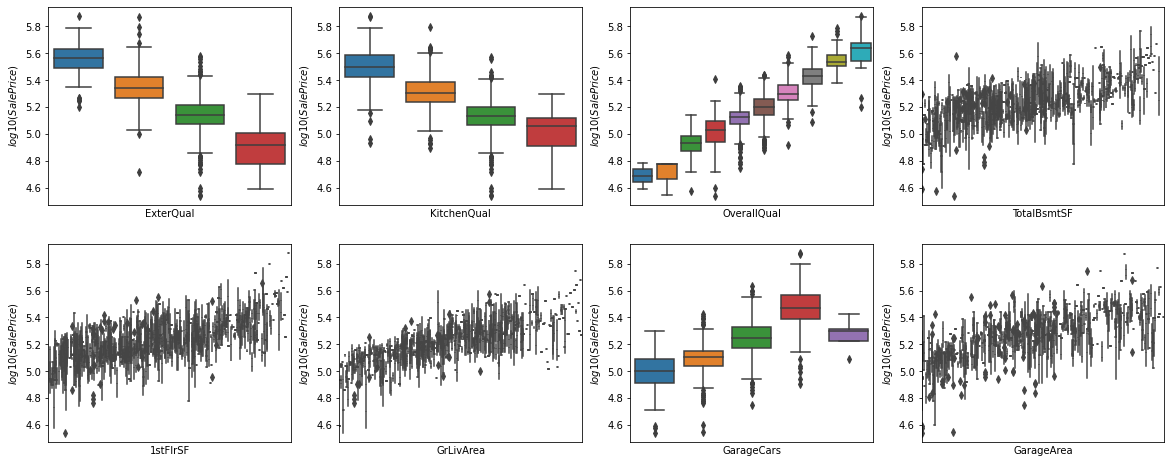

In [58]:
plt.figure(figsize=(20, 8))
for k in np.arange(corr_dat.shape[-1]):
    plt.subplot(corr_dat.shape[-1]//plot_factor,plot_factor,k+1)
    sns.boxplot(x=corr_dat.iloc[:,k], y=np.log10(y_train))
    plt.xticks([]); plt.ylabel('$log10(SalePrice)$')
plt.show();

We also visualize the target variable, <u>SalePrice</u>. We notice that these values are log-normally distributed. There are a very small amount of extremely expensive houses, while the vast majority are closer to the average. Therefore, taking the logarithm of this will make them Normally distributed. This will help a lot for the regression techniques, and therefore we will be working with the natural log of SalePrice from now on. 

In [59]:
target = np.log10(y_train)
print('       SalePrice: Mean {:.3e} | Std. Dev {:.3e}'.format(y_train.mean(), y_train.std()))
print('Log10(SalePrice): Mean {:.3f}     | Std. Dev {:.3f}'.format(target.mean(), target.std()))

       SalePrice: Mean 1.809e+05 | Std. Dev 7.944e+04
Log10(SalePrice): Mean 5.222     | Std. Dev 0.173


In [60]:
print('       SalePrice: Skewness={:.3f} | Kurtosis={:.3f}'.format(y_train.skew(), y_train.kurt()))
print('Log10(SalePrice): Skewness={:.3f} | Kurtosis={:.3f}'.format(target.skew(), target.kurt()))

       SalePrice: Skewness=1.883 | Kurtosis=6.536
Log10(SalePrice): Skewness=0.121 | Kurtosis=0.810


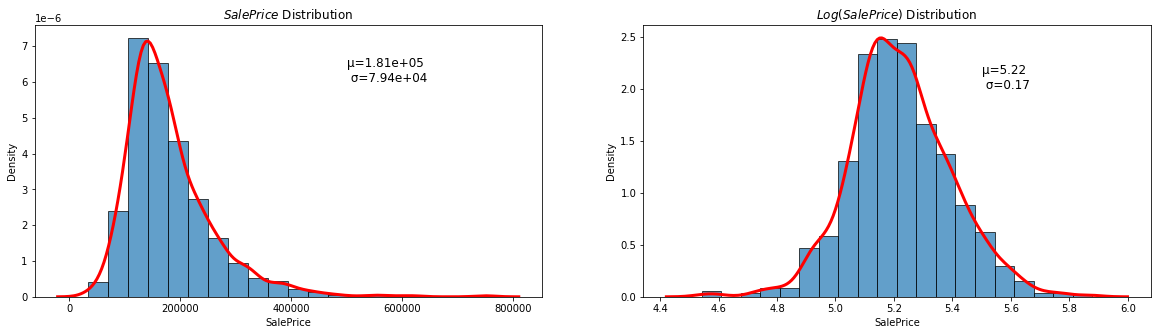

In [61]:
plt.figure(figsize=(20,5))

ax1 = plt.subplot(121)
plt.title('$SalePrice$ Distribution')
ax1.text(5E5,6E-6, 'μ={:.2e}\n σ={:.2e}'.format(y_train.mean(), y_train.std()), fontsize=12)
plt.hist(y_train, density=True, bins=20, alpha=0.7, histtype='bar', ec='black')
sns.kdeplot(y_train, linewidth=3, c='r')

ax2 = plt.subplot(122)
plt.title('$Log(SalePrice)$ Distribution')
ax2.text(5.5, 2, 'μ={:.2f}\n σ={:.2f}'.format(target.mean(), target.std()), fontsize=12)
plt.hist(target, density=True, bins=20, alpha=0.7, histtype='bar', ec='black')
sns.kdeplot(target, linewidth=3, c='r')

plt.show();

On a slightly different note, we will plot the relationship between two variables at a time and the target log10(SalePrice), using Seaborn, and try to fit a linear regressor onto the data. This will test for linearity and for possible colinearity, and will also compute the $r^2$ coefficient and $p$ value for the regression estimate.

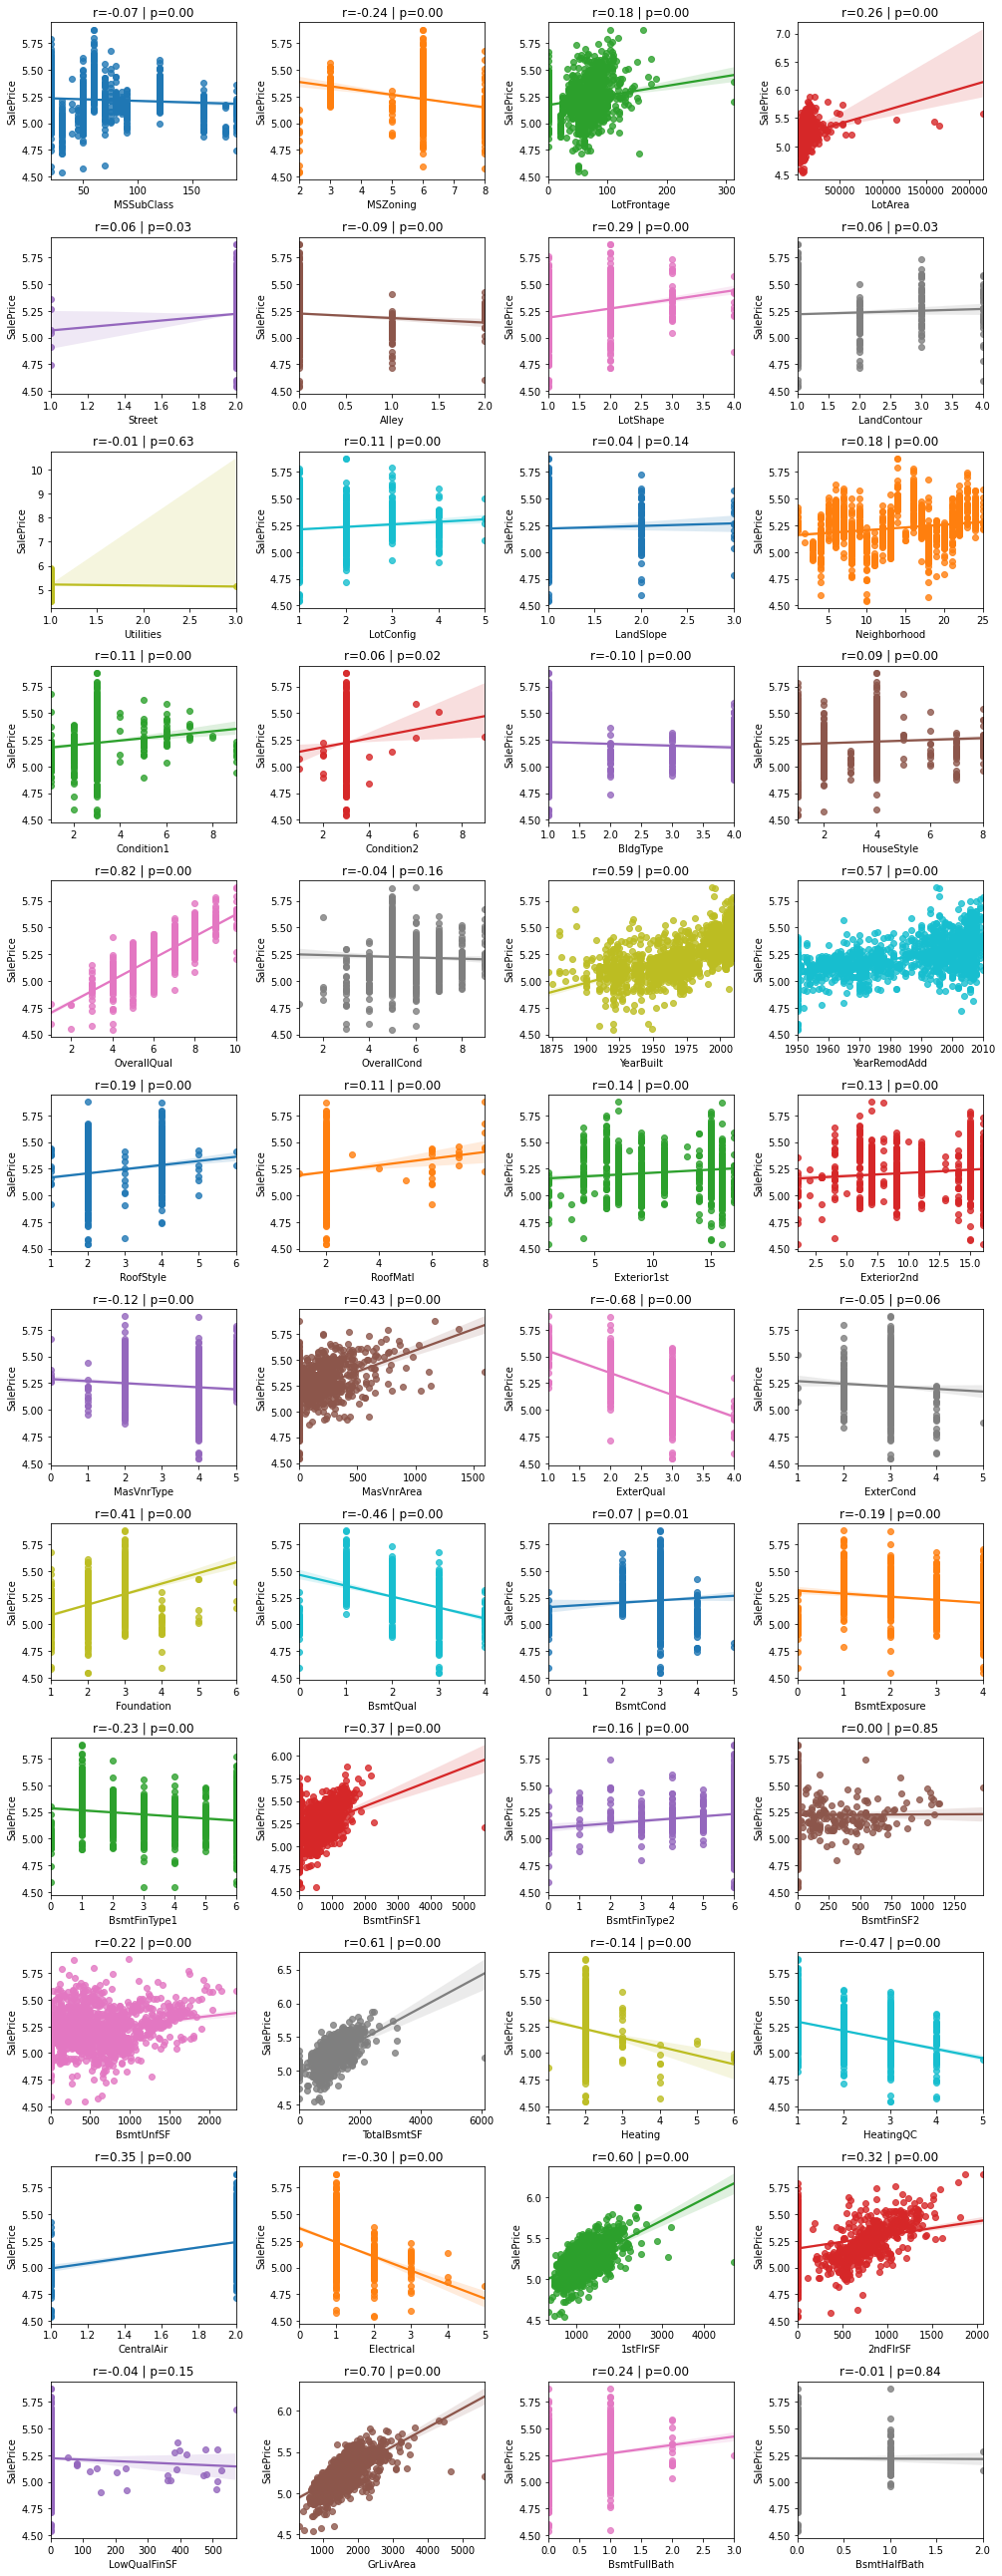

In [62]:
nr_rows, nr_cols = 12, 4
colors = sns.color_palette()

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(x=x_train[li_plot_num_feats[i]], y=target, 
                        ax = axs[r][c], color=colors[i % 10])
            stp = stats.pearsonr(x_train[li_plot_num_feats[i]], target)
            str_title = "r="+"{0:.2f}".format(stp[0])+" | "+"p="+"{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=12)
            
plt.tight_layout()    
plt.show()

***

# 4. Exploratory Data Analysis

After understanding the data statistics and relationships, we will now try to do some basic data analytics on the preprocessed data.

In [63]:
def plot_corr_matrix(df, nr_c, targ) :
    corr_abs = df.corr().abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)
    plt.figure(figsize=(nr_c, nr_c))
    plt.title('Correlation Matrix')
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, cbar_kws={'shrink':0.8},
                yticklabels=cols.values, xticklabels=cols.values)
    plt.show();

In [64]:
print('Significant Correlation Bound: ', corr_bound)
print('Shape of training data above correlation bound: ', corr_dat.shape)

Significant Correlation Bound:  0.6
Shape of training data above correlation bound:  (1460, 8)


In [65]:
target_name = 'SalePrice'

corr_abs = train_df.corr().abs()
ser_corr = corr_abs.nlargest(len(numerical_feats), target_name)[target_name]

cols_abv_corr_limit = list(ser_corr[ser_corr.values >= corr_bound].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values < corr_bound].index)

nr_feats = len(cols_abv_corr_limit)

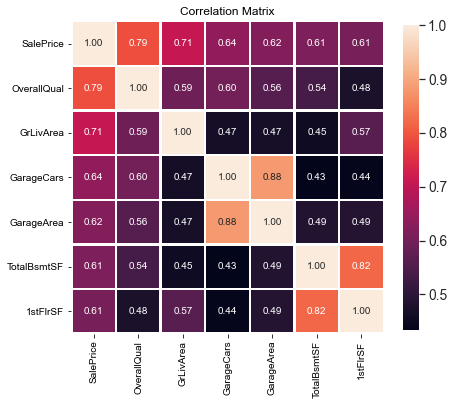

In [66]:
plot_corr_matrix(train_df, nr_feats, target_name)

From the covariance matrix, we see that for some features like 'OverallQual' there is a strong linear correlation (0.8 approximately) to the target. For other features like 'MSSubClass' or 'MiscFeature' the correlation is very weak.

Scale the correlation-based data so that all features values are between 0 and 1. This will help greatly for the regression modeling and the visualization and interpretation of the models and the data.

In [67]:
scaler = StandardScaler()
x_train_s = scaler.fit_transform(corr_dat)

Perform <u>PCA</u> to encode the correlation-based data into orthogonal singular vectors that will best describe the variability of the data. This will help visualize and try and classify clusters of data based on these new principal directions.

In [68]:
n_components = 8
pca = PCA(n_components=n_components)
pca.fit(x_train_s)

#variance explained by each PC
print('PC Variance Explained: {}'.format(pca.explained_variance_ratio_))
print('Cumulative Variance Explained: {}'.format(np.sum(pca.explained_variance_ratio_).round(4)))

PC Variance Explained: [0.59394484 0.12746352 0.10382664 0.07290565 0.038667   0.03053255
 0.01878177 0.01387803]
Cumulative Variance Explained: 1.0


We see that with 4 PC's, for instance, we can explain approximately 90% of the variance in the scaled, clean data set.

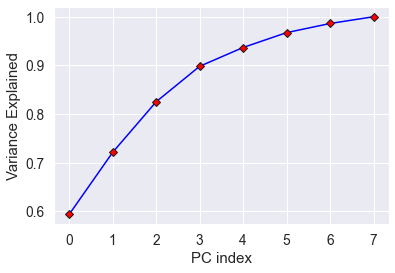

In [69]:
#plot n_PC-vs-varExplained
plt.figure()
plt.plot(range(len(np.cumsum(pca.explained_variance_ratio_))), np.cumsum(pca.explained_variance_ratio_), 
         '-bD',  c='blue', mfc='red', mec='k')
plt.xlabel('PC index')
plt.ylabel('Variance Explained')
plt.grid('on')
plt.show();

We can see that PC1 and PC3 help us find a slight classification in PC-space for the categorical variables 'ExterQual', 'KitchenQual', 'OverallQual', and 'GarageCars'; especially the last one. 

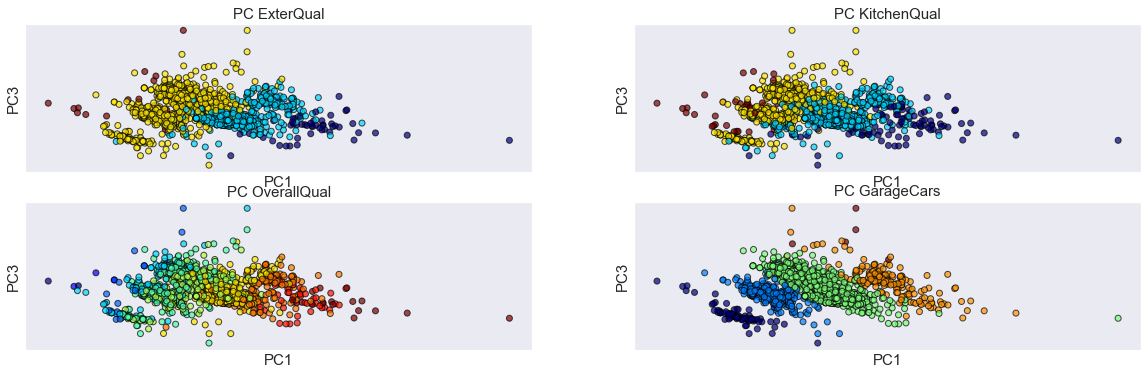

In [70]:
x_trans = pca.transform(x_train_s)  

plt.figure(figsize=(20,6))
plt.subplot(221)
plt.scatter(x_trans[:,0], x_trans[:,2], c=corr_dat['ExterQual'], cmap='jet', edgecolors="black", alpha=0.7)
plt.title('PC ExterQual'); plt.xlabel('PC1'); plt.ylabel('PC3'); plt.xticks([]); plt.yticks([])
plt.subplot(222)
plt.scatter(x_trans[:,0], x_trans[:,2], c=corr_dat['KitchenQual'], cmap='jet', edgecolors="black", alpha=0.7)
plt.title('PC KitchenQual'); plt.xlabel('PC1'); plt.ylabel('PC3'); plt.xticks([]); plt.yticks([])
plt.subplot(223)
plt.scatter(x_trans[:,0], x_trans[:,2], c=corr_dat['OverallQual'], cmap='jet', edgecolors="black", alpha=0.7)
plt.title('PC OverallQual'); plt.xlabel('PC1'); plt.ylabel('PC3'); plt.xticks([]); plt.yticks([])
plt.subplot(224)
plt.scatter(x_trans[:,0], x_trans[:,2], c=corr_dat['GarageCars'], cmap='jet', edgecolors="black", alpha=0.7)
plt.title('PC GarageCars'); plt.xlabel('PC1'); plt.ylabel('PC3'); plt.xticks([]); plt.yticks([])
plt.show();

On the other hand, we can perform t-distributed Stochastic Neighbor Embedding (TSNE), which converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. Here, we can see a good separation for 'ExterQual' and 'GarageCars' features, proving useful for predicting sale price using these variables.

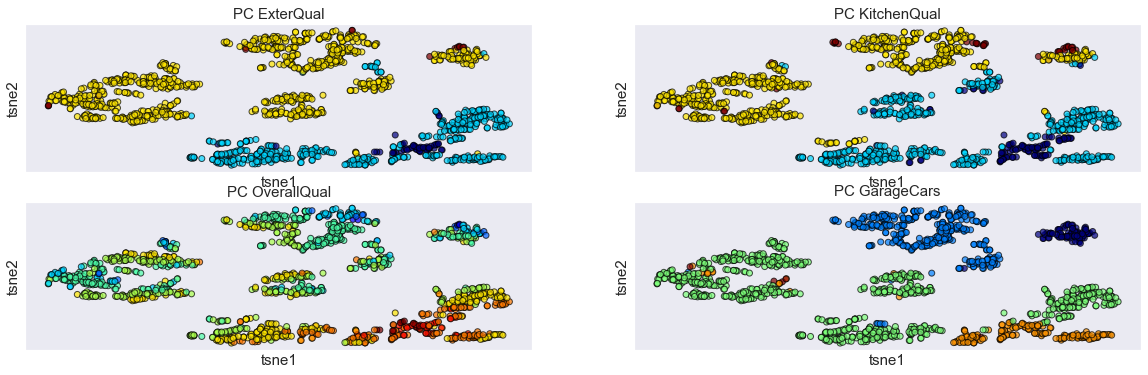

In [71]:
tsne = TSNE(n_components = 2).fit_transform(x_train_s)

plt.figure(figsize=(20,6))
plt.subplot(221)
plt.scatter(tsne[:,0], tsne[:,1], c=corr_dat['ExterQual'], cmap='jet', edgecolors="black", alpha=0.7)
plt.title('PC ExterQual'); plt.xlabel('tsne1'); plt.ylabel('tsne2'); plt.xticks([]); plt.yticks([])
plt.subplot(222)
plt.scatter(tsne[:,0], tsne[:,1], c=corr_dat['KitchenQual'], cmap='jet', edgecolors="black", alpha=0.7)
plt.title('PC KitchenQual'); plt.xlabel('tsne1'); plt.ylabel('tsne2'); plt.xticks([]); plt.yticks([])
plt.subplot(223)
plt.scatter(tsne[:,0], tsne[:,1], c=corr_dat['OverallQual'], cmap='jet', edgecolors="black", alpha=0.7)
plt.title('PC OverallQual'); plt.xlabel('tsne1'); plt.ylabel('tsne2'); plt.xticks([]); plt.yticks([])
plt.subplot(224)
plt.scatter(tsne[:,0], tsne[:,1], c=corr_dat['GarageCars'], cmap='jet', edgecolors="black", alpha=0.7)
plt.title('PC GarageCars'); plt.xlabel('tsne1'); plt.ylabel('tsne2'); plt.xticks([]); plt.yticks([])
plt.show();

Next, we use <u>K-Means Clustering </u> and <u> Hierarchical Clustering </u> to try and find some relationships in the data. This algorihtm is unsupervised, and therefore tries to cluster the data based on similar predictor values toward the target. This will allow us to observe how we can start classifying and relating the data to the SalePrice. Using 3 clusters we might be able to visualize high/medium/low price houses based on these different highly-correlated predcitor features.

In [72]:
n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters).fit(X=x_train_s, y=target).labels_
hclust = AgglomerativeClustering(n_clusters = n_clusters).fit(X=x_train_s, y=target).labels_
gmm    = GaussianMixture(n_components=n_clusters).fit_predict(X=x_train_s, y=target)

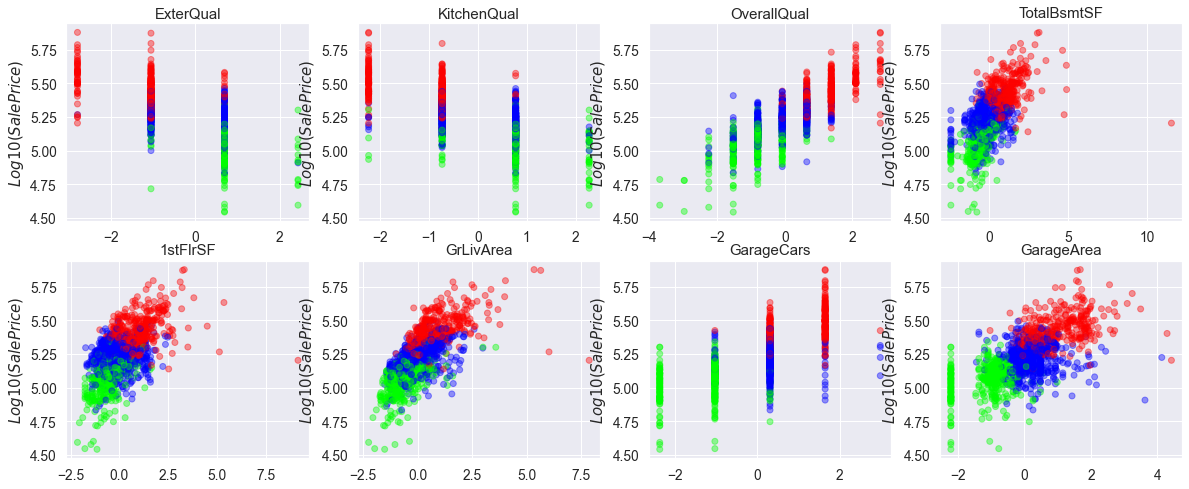

In [73]:
#select the clustering method to visualize
clust_method = kmeans 

plt.figure(figsize=(20,8))
for k in range(len(corr_dat.columns)):
    plt.subplot(x_train_s.shape[-1]//plot_factor,plot_factor,k+1)
    plt.title('{}'.format(corr_dat.columns[k]))
    plt.scatter(x_train_s[:,k], target, c=clust_method, cmap='brg', alpha=0.4)
    plt.ylabel('$Log10(SalePrice)$')
plt.show();

We now perform <u> Local Outlier Factor </u> analysis to try and see if we can find any major outliers in the highly-correlated subset of the data. 

In [74]:
lof = LocalOutlierFactor(n_neighbors=5)
lof.fit_predict(X=x_train_s, y=target)
lof_factors = -lof.negative_outlier_factor_
print('Local Outlier Factors: {}'.format(lof_factors)) #outliers are further away from 1

# let outliers be those that are more than this upper bound value
lof_outliers_bound = 5

Local Outlier Factors: [0.9848064  0.97417749 1.10287748 ... 2.64963468 0.95880616 1.08014456]


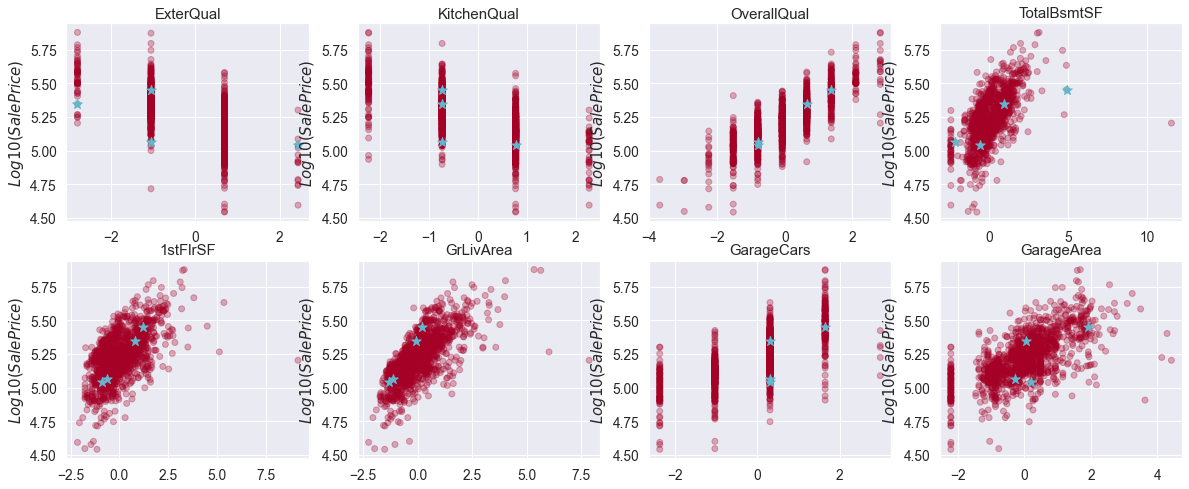

In [75]:
plt.figure(figsize=(20,8))
for k in range(len(corr_dat.columns)):
    plt.subplot(x_train_s.shape[-1]//plot_factor,plot_factor,k+1)
    plt.title('{}'.format(corr_dat.columns[k]))
    plt.scatter(x_train_s[:,k], target, c=lof_factors>lof_outliers_bound, cmap='RdYlGn', alpha=0.3)
    plt.scatter(x_train_s[:,k][lof_factors>lof_outliers_bound], target[lof_factors>lof_outliers_bound], 
                c='c', alpha=1, marker="*", s=100)
    plt.ylabel('$Log10(SalePrice)$')
plt.show();

In [76]:
df_all = pd.concat([x_train, x_test])

len_train = x_train.shape[0]

In [77]:
# StandardScaler from Scikit-Learn
from sklearn.preprocessing import StandardScaler

# Initialize instance of StandardScaler
scaler = StandardScaler()

# Fit and transform item_data
data_scaled = scaler.fit_transform(df_all)

# Display first 5 rows of item_data_scaled
data_scaled[:5]

array([[ 0.06733141, -0.10861873,  0.21607482, -0.21787869,  0.06424926,
        -0.25355997, -0.70189976, -0.30847126,  0.        , -0.52215438,
        -0.21626042, -1.24756925, -0.05704881, -0.02099186, -0.43148064,
         0.74057214,  0.6461834 , -0.5072842 ,  1.0462576 ,  0.89683293,
        -0.48292558, -0.11692303,  0.79453692,  0.79756559, -1.31848566,
         0.52903417, -1.03980539,  0.23004678,  0.834618  , -0.44745004,
         0.15158359,  0.65275866, -1.07980856,  0.58114542,  0.35402201,
        -0.29302528, -0.93416481, -0.44307791, -0.1032061 , -0.88561933,
         0.26828983, -0.27700532, -0.77386103,  1.20737855, -0.10119702,
         0.41354722,  1.08733408, -0.24971861,  0.78136581,  1.23259887,
         0.16992709, -0.20769847, -0.73567911,  0.98684937, -0.23598698,
        -0.92431121, -0.94402138, -0.58514876,  0.29500243, -0.07043436,
         0.30703976,  0.34936362,  0.17460855,  0.18712257, -0.31502962,
        -0.74076041,  0.20000601, -0.35960075, -0.1

In [78]:
pca = PCA(n_components=n_components)
pca.fit(data_scaled)

PC_items = pca.transform(data_scaled)

In [79]:
# Put PC_items into a dataframe
items_pca = pd.DataFrame(PC_items)

# Name the columns
items_pca.columns = ['PC{}'.format(i + 1) for i in range(PC_items.shape[1])]

# Update its index
items_pca.index = df_all.index

# Display first 5 rows
items_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,2.111769,0.623513,-0.809276,-1.500515,1.454763,-0.905353,-0.948937,-0.412448
1,0.410186,-1.114790,1.850089,0.976212,-0.036418,-0.776231,-0.332173,-0.961066
2,2.806533,0.315929,-0.529763,-0.746435,1.464526,-1.031730,-1.281173,0.291367
3,-0.776126,-1.771055,-1.645375,0.974100,0.549295,0.529383,-1.201984,0.989487
4,5.131392,0.234495,-1.247074,0.997057,1.725620,-0.585945,-0.920764,-0.051056


In [80]:
len_train = x_train.shape[0]

pca_xtrain = items_pca[:len_train]
pca_xtest = items_pca[len_train:]

In [81]:
# Dataframe dimensions
print(pca_xtrain.shape)
print("*"*50)
print(pca_xtest.shape)

(1460, 8)
**************************************************
(1459, 8)


In [82]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns

# Scikit-Learn for Modeling
import sklearn

# Import Elastic Net, Ridge Regression, and Lasso Regression
from sklearn.linear_model import ElasticNet, Ridge, Lasso

# Import Random Forest and Gradient Boosted Trees
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [83]:
# Function for creating model pipelines
from sklearn.pipeline import make_pipeline

In [84]:
# For standardization
from sklearn.preprocessing import StandardScaler

In [85]:
make_pipeline(StandardScaler(), Lasso(random_state=123))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(random_state=123))])

In [86]:
# Create pipelines dictionary
pipelines = {
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state=123)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state=123)),
    'enet'  : make_pipeline(StandardScaler(), ElasticNet(random_state=123))
}

In [87]:
# Add a pipeline for 'rf'
pipelines['rf'] = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123))

# Add a pipeline for 'gb'
pipelines['gb'] = make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=123))

In [88]:
# Check that we have all 5 algorithms, and that they are all pipelines
for key, value in pipelines.items():
    print( key, type(value) )

lasso <class 'sklearn.pipeline.Pipeline'>
ridge <class 'sklearn.pipeline.Pipeline'>
enet <class 'sklearn.pipeline.Pipeline'>
rf <class 'sklearn.pipeline.Pipeline'>
gb <class 'sklearn.pipeline.Pipeline'>


In [89]:
# List tuneable hyperparameters of our Lasso pipeline
pipelines['lasso'].get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('lasso', Lasso(random_state=123))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'lasso': Lasso(random_state=123),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'lasso__alpha': 1.0,
 'lasso__copy_X': True,
 'lasso__fit_intercept': True,
 'lasso__max_iter': 1000,
 'lasso__normalize': False,
 'lasso__positive': False,
 'lasso__precompute': False,
 'lasso__random_state': 123,
 'lasso__selection': 'cyclic',
 'lasso__tol': 0.0001,
 'lasso__warm_start': False}

In [90]:
# Lasso hyperparameters
lasso_hyperparameters = { 
    'lasso__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10] 
}

# Ridge hyperparameters
ridge_hyperparameters = { 
    'ridge__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]  
}

In [91]:
# Elastic Net hyperparameters
enet_hyperparameters = { 
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],                        
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]  
}

In [92]:
# Random forest hyperparameters
rf_hyperparameters = { 
    'randomforestregressor__n_estimators' : [100, 200],
    'randomforestregressor__max_features': ['auto', 'sqrt', 0.33],
}

In [93]:
# Boosted tree hyperparameters
gb_hyperparameters = { 
    'gradientboostingregressor__n_estimators': [100, 200],
    'gradientboostingregressor__learning_rate' : [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [1, 3, 5]
}

In [94]:
# Create hyperparameters dictionary
hyperparameters = {
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters,
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters,
    'enet' : enet_hyperparameters
}

In [95]:
for key in ['enet', 'gb', 'ridge', 'rf', 'lasso']:
    if key in hyperparameters:
        if type(hyperparameters[key]) is dict:
            print( key, 'was found in hyperparameters, and it is a grid.' )
        else:
            print( key, 'was found in hyperparameters, but it is not a grid.' )
    else:
        print( key, 'was not found in hyperparameters')

enet was found in hyperparameters, and it is a grid.
gb was found in hyperparameters, and it is a grid.
ridge was found in hyperparameters, and it is a grid.
rf was found in hyperparameters, and it is a grid.
lasso was found in hyperparameters, and it is a grid.


In [96]:
# Helper for cross-validation
from sklearn.model_selection import GridSearchCV

In [97]:
# Create cross-validation object from Lasso pipeline and Lasso hyperparameters
model = GridSearchCV(pipelines['lasso'], hyperparameters['lasso'], cv=10, n_jobs=-1)

In [98]:
type(model)

sklearn.model_selection._search.GridSearchCV

In [99]:
# Fit and tune model
model.fit(pca_xtrain, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lasso', Lasso(random_state=123))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1,
                                          5, 10]})

In [100]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(pca_xtrain, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.


In [101]:
# Check that we have 5 cross-validation objects
for key, value in fitted_models.items():
    print( key, type(value) )

lasso <class 'sklearn.model_selection._search.GridSearchCV'>
ridge <class 'sklearn.model_selection._search.GridSearchCV'>
enet <class 'sklearn.model_selection._search.GridSearchCV'>
rf <class 'sklearn.model_selection._search.GridSearchCV'>
gb <class 'sklearn.model_selection._search.GridSearchCV'>


In [102]:
from sklearn.exceptions import NotFittedError

for name, model in fitted_models.items():
    try:
        pred = model.predict(pca_xtest)
        print(name, 'has been fitted.')
    except NotFittedError as e:
        print(repr(e))

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.


In [103]:
# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print( name, model.best_score_ )

lasso 0.7774957168378835
ridge 0.7775527690836898
enet 0.7775557020686957
rf 0.8519125443953515
gb 0.8659809238554221


In [104]:
# Import r2_score and mean_absolute_error functions
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [105]:
# Display fitted random forest object
fitted_models['rf']

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=123))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_features': ['auto', 'sqrt',
                                                                 0.33],
                         'randomforestregressor__n_estimators': [100, 200]})

In [106]:
# Predict test set using fitted random forest
pred = fitted_models['rf'].predict(pca_xtest)

In [107]:
# Calculate and print R^2 and MAE, for training data set
pred_train = fitted_models['rf'].predict(pca_xtrain)
print( 'R^2:', r2_score(y_train, pred_train ))
print( 'MAE:', mean_absolute_error(y_train, pred_train))

R^2: 0.980023153389449
MAE: 6803.581784246575


In [108]:
print(pred)

[122921.79  162542.055 189491.75  ... 165545.66  123064.5   230864.5  ]


In [109]:
pred.shape

(1459,)

In [110]:
df_test_id_test = pd.read_csv("test.csv")
id_test = df_test_id_test['Id']

pred_pd = pd.DataFrame()
pred_pd['Id'] = id_test
pred_pd['SalePrice'] = pred

pred_pd.head
pred_pd.to_csv('submission_StochasticResults.csv',index=False)

***

<h1> Concluding Remarks: </h1>

- <u> Remarks </u><br>
    * The data has a different types of predictor features, including categorical and numerical. We mapped all categorical features into classes, which can then be used for supervised learning techniques.
    * The target variables, SalePrice, is log-normally distributed and thus any regression algorithms should be predicting the log10(SalePrice) pseudofeature instead.
    * Data preprocessing and analysis included statistical and visual analysis; as well as unsupervised learning, also known as clustering analysis.
    * Some outliers are still present in the data, though they are only but a small percentage of the instances in the highly-correlated features selected.


- <u> Conclusion </u><br>
    * The Ames Housing data set is a complex yet versatile data set from machine learning projects. 
    * Preprocessing and data wrangling is crucial for explointing the full potential of all features.
    * The data is now ready to be used in different regression models to predict SalePrice from the features.
    

- <u> Part 2: Regression </u><br>
We will attempt to use 6 different regression algorithms on the preprocessed data set. These potentially include linear regression, regularized regression, boosting, SVM, random forest, and neural networks. We will then compare the performance of the differnet algorithms in predicting the (logarithm) SalePrice using the (subset) 79 (preprocessed) predictors provided. The mean-squared error metric will be used for optimization, and we hope to produce very accurate and itneresting predictive models for the Ames Housing dataset.

***

# End of Notebook